# Phase 3: Model Training & Evaluation

## Objective
Train a Random Forest classifier to detect timestomped files using engineered features from Phase 2.

## What We're Doing
1. **Data Splitting**: Case-based stratified split (prevent data leakage)
2. **Handle Class Imbalance**: SMOTE oversampling + class weights
3. **Model Training**: Random Forest with hyperparameter tuning
4. **Evaluation**: Precision-Recall focus (forensic context)
5. **Interpretability**: Feature importance analysis

## Input
- **Engineered Dataset:** `data/processed/Phase 2 - Feature Engineering/features_engineered.csv`
- **Records:** 778,692 events
- **Features:** 87 columns
- **Labels:** 247 timestomped events (1:3,151 imbalance)

## Output
- **Trained Model:** Random Forest classifier
- **Evaluation Reports:** Classification metrics, confusion matrix, ROC/PR curves
- **Feature Importance:** Top predictive features

## Key Challenge
**Extreme Class Imbalance (1:3,151)** - In forensic context, we must:
- **Minimize False Positives** (don't flag benign files as timestomped)
- **Maximize Recall** (catch actual timestomping attempts)
- **Balance** precision and recall based on forensic investigation cost

---
## 1. Setup & Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    precision_recall_curve, 
    average_precision_score,
    f1_score,
    precision_score,
    recall_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 8)

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


In [4]:
# Define paths
notebook_dir = Path.cwd()
print(f"Current working directory: {notebook_dir}")

# Navigate to project root
if 'notebooks' in str(notebook_dir):
    BASE_DIR = notebook_dir.parent.parent / 'data'
else:
    BASE_DIR = Path('data')

INPUT_FILE = BASE_DIR / 'processed' / 'Phase 2 - Feature Engineering' / 'features_engineered.csv'
OUTPUT_DIR = BASE_DIR / 'processed' / 'Phase 3 - Model Training'

# Ensure output directory exists
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n📂 Directory Configuration:")
print(f"  Input:  {INPUT_FILE} {'✓' if INPUT_FILE.exists() else '✗ NOT FOUND'}")
print(f"  Output: {OUTPUT_DIR} ✓")


Current working directory: /Users/soni/Github/Digital-Detectives_Thesis

📂 Directory Configuration:
  Input:  data/processed/Phase 2 - Feature Engineering/features_engineered.csv ✓
  Output: data/processed/Phase 3 - Model Training ✓


---
## 2. Load Data & Initial Exploration

In [5]:
print("\n" + "=" * 80)
print("LOADING ENGINEERED FEATURES")
print("=" * 80)

# Load dataset
df = pd.read_csv(INPUT_FILE, encoding='utf-8-sig')

print(f"\n📊 Dataset Loaded:")
print(f"   Records: {len(df):,}")
print(f"   Features: {len(df.columns)}")
print(f"   Timestomped events: {df['is_timestomped'].sum()}")

# Class distribution
print(f"\n📈 Class Distribution:")
class_counts = df['is_timestomped'].value_counts().sort_index()
for label, count in class_counts.items():
    pct = count / len(df) * 100
    print(f"   Class {int(label)}: {count:,} ({pct:.3f}%)")

imbalance_ratio = class_counts[0] / class_counts[1]
print(f"\n   ⚠️  Imbalance Ratio: 1:{int(imbalance_ratio)}")

# Memory usage
print(f"\n💾 Memory Usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")



LOADING ENGINEERED FEATURES

📊 Dataset Loaded:
   Records: 778,692
   Features: 87
   Timestomped events: 247.0

📈 Class Distribution:
   Class 0: 778,445 (99.968%)
   Class 1: 247 (0.032%)

   ⚠️  Imbalance Ratio: 1:3151

💾 Memory Usage: 337.89 MB


---
## 3. Data Preparation: Feature Selection & Type Handling


In [6]:
print("\n" + "=" * 80)
print("DATA PREPARATION")
print("=" * 80)

# 1. Separate features from target
print(f"\n1️⃣ Separating features and target...")

# Columns to exclude from features
cols_to_exclude = [
    'is_timestomped',           # Target variable
    'is_timestomped_lf',        # Artifact-level labels (redundant)
    'is_timestomped_usn',       # Artifact-level labels (redundant)
    'timestomp_tool_executed',  # Feature but highly correlated with target
    'timestomp_tool_executed_lf',
    'timestomp_tool_executed_usn',
    'case_id',                  # Will use for stratified split, not as feature
    'eventtime_dt',             # Datetime object, already extracted features
]

# Get feature columns
feature_cols = [col for col in df.columns if col not in cols_to_exclude]

print(f"   Total columns: {len(df.columns)}")
print(f"   Excluded columns: {len(cols_to_exclude)}")
print(f"   Feature columns: {len(feature_cols)}")

# 2. Handle data types
print(f"\n2️⃣ Handling data types...")

# Convert bool to int for sklearn compatibility
bool_cols = df[feature_cols].select_dtypes(include='bool').columns.tolist()
if bool_cols:
    print(f"   Converting {len(bool_cols)} boolean columns to int...")
    for col in bool_cols:
        df[col] = df[col].astype(int)

# Check for any remaining non-numeric columns
non_numeric = df[feature_cols].select_dtypes(exclude=['int64', 'float64']).columns.tolist()
if non_numeric:
    print(f"   ⚠️  Non-numeric columns found: {non_numeric}")
else:
    print(f"   ✓ All feature columns are numeric")

# 3. Create X and y
print(f"\n3️⃣ Creating feature matrix (X) and target vector (y)...")

X = df[feature_cols].copy()
y = df['is_timestomped'].copy()
case_ids = df['case_id'].copy()

print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")
print(f"   y distribution: {y.value_counts().to_dict()}")

# 4. Check for missing values
print(f"\n4️⃣ Checking for missing values...")

missing_counts = X.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]

if len(missing_counts) > 0:
    print(f"   ⚠️  Missing values found in {len(missing_counts)} columns:")
    for col, count in missing_counts.items():
        pct = count / len(X) * 100
        print(f"     {col}: {count:,} ({pct:.2f}%)")
    
    # Fill missing values with 0 (conservative approach)
    print(f"\n   Filling missing values with 0...")
    X = X.fillna(0)
else:
    print(f"   ✓ No missing values found")

print(f"\n✅ Data preparation complete!")
print(f"   Final X shape: {X.shape}")
print(f"   Features: {X.shape[1]}")
print(f"   Samples: {X.shape[0]}")


DATA PREPARATION

1️⃣ Separating features and target...
   Total columns: 87
   Excluded columns: 8
   Feature columns: 79

2️⃣ Handling data types...
   Converting 43 boolean columns to int...
   ✓ All feature columns are numeric

3️⃣ Creating feature matrix (X) and target vector (y)...
   X shape: (778692, 79)
   y shape: (778692,)
   y distribution: {0.0: 778445, 1.0: 247}

4️⃣ Checking for missing values...
   ⚠️  Missing values found in 8 columns:
     hour_of_day: 8 (0.00%)
     day_of_week: 8 (0.00%)
     day_of_month: 8 (0.00%)
     month: 8 (0.00%)
     year: 8 (0.00%)
     creation_year_delta: 635,582 (81.62%)
     modified_year_delta: 635,582 (81.62%)
     event_count_per_file: 12,926 (1.66%)

   Filling missing values with 0...

✅ Data preparation complete!
   Final X shape: (778692, 79)
   Features: 79
   Samples: 778692


---
## 4. Train/Test Split: Case-Based Stratification

**Why Case-Based Split?**
- **Prevent Data Leakage:** Events from the same case should not appear in both train and test sets
- **Realistic Evaluation:** Model must generalize to unseen cases (real-world scenario)
- **Maintain Label Distribution:** Stratify to preserve class imbalance ratio in both sets


In [7]:
print("\n" + "=" * 80)
print("TRAIN/TEST SPLIT: CASE-BASED STRATIFICATION")
print("=" * 80)

# 1. Analyze case distribution
print(f"\n1️⃣ Analyzing case distribution...")

case_stats = df.groupby('case_id').agg({
    'is_timestomped': ['sum', 'count']
}).reset_index()
case_stats.columns = ['case_id', 'timestomped_count', 'total_events']
case_stats['benign_count'] = case_stats['total_events'] - case_stats['timestomped_count']

print(f"\n   Case Statistics:")
print(case_stats.to_string(index=False))

# 2. Split strategy
print(f"\n2️⃣ Split Strategy:")
print(f"   We have {len(case_stats)} cases with varying timestomped event counts")
print(f"   Challenge: Some cases have 0 timestomped events")
print(f"   Solution: Use StratifiedGroupKFold-like approach or manual stratified split")

# 3. Manual stratified split by case
print(f"\n3️⃣ Performing case-based stratified split...")

# Identify cases with and without timestomped events
cases_with_labels = case_stats[case_stats['timestomped_count'] > 0]['case_id'].tolist()
cases_without_labels = case_stats[case_stats['timestomped_count'] == 0]['case_id'].tolist()

print(f"   Cases WITH timestomped events: {len(cases_with_labels)} → {cases_with_labels}")
print(f"   Cases WITHOUT timestomped events: {len(cases_without_labels)} → {cases_without_labels}")

# Strategy: 80/20 split, ensuring both train and test have timestomped events
# Put majority of labeled cases in train, keep some for test
from sklearn.model_selection import train_test_split as split_list

if len(cases_with_labels) >= 2:
    # Split labeled cases 80/20
    train_cases_labeled, test_cases_labeled = split_list(
        cases_with_labels, 
        test_size=0.2, 
        random_state=42
    )
else:
    # If only 1-2 labeled cases, put all in train
    train_cases_labeled = cases_with_labels
    test_cases_labeled = []

# Split unlabeled cases 80/20
if len(cases_without_labels) > 0:
    train_cases_unlabeled, test_cases_unlabeled = split_list(
        cases_without_labels,
        test_size=0.2,
        random_state=42
    )
else:
    train_cases_unlabeled = []
    test_cases_unlabeled = []

# Combine
train_cases = train_cases_labeled + train_cases_unlabeled
test_cases = test_cases_labeled + test_cases_unlabeled

print(f"\n   Train cases ({len(train_cases)}): {sorted(train_cases)}")
print(f"   Test cases ({len(test_cases)}): {sorted(test_cases)}")

# Create train/test masks
train_mask = case_ids.isin(train_cases)
test_mask = case_ids.isin(test_cases)

# Split data
X_train = X[train_mask].copy()
X_test = X[test_mask].copy()
y_train = y[train_mask].copy()
y_test = y[test_mask].copy()

print(f"\n4️⃣ Split Results:")
print(f"   Train set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"     - Timestomped: {y_train.sum()}")
print(f"     - Benign: {(y_train == 0).sum()}")
print(f"     - Imbalance: 1:{int((y_train == 0).sum() / y_train.sum())}")

print(f"\n   Test set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"     - Timestomped: {y_test.sum()}")
print(f"     - Benign: {(y_test == 0).sum()}")
if y_test.sum() > 0:
    print(f"     - Imbalance: 1:{int((y_test == 0).sum() / y_test.sum())}")
else:
    print(f"     - ⚠️  WARNING: No timestomped events in test set!")

print(f"\n✅ Case-based split complete!")


TRAIN/TEST SPLIT: CASE-BASED STRATIFICATION

1️⃣ Analyzing case distribution...

   Case Statistics:
 case_id  timestomped_count  total_events  benign_count
       1                2.0        106953      106951.0
       2                1.0         52483       52482.0
       3                2.0         59080       59078.0
       4                2.0         62406       62404.0
       5                1.0         64584       64583.0
       6               71.0         64347       64276.0
       7                1.0         59324       59323.0
       8               31.0         59585       59554.0
       9               36.0         61327       61291.0
      10               31.0         59854       59823.0
      11                1.0         64332       64331.0
      12               68.0         64417       64349.0

2️⃣ Split Strategy:
   We have 12 cases with varying timestomped event counts
   Challenge: Some cases have 0 timestomped events
   Solution: Use StratifiedGroupKFold-li

---
## 5. Handle Class Imbalance: SMOTE Oversampling
**Why SMOTE?**
- **Synthetic Minority Oversampling Technique:** Creates synthetic timestomped examples
- **Better than Random Oversampling:** Generates new samples along feature space, not duplicates
- **Preserves Decision Boundary:** Helps model learn minority class patterns

**Important:** Only apply SMOTE to training set (never test set!)

In [8]:
print("\n" + "=" * 80)
print("CLASS IMBALANCE HANDLING: SMOTE")
print("=" * 80)

print(f"\n1️⃣ Before SMOTE:")
print(f"   Train samples: {len(X_train):,}")
print(f"   Timestomped: {y_train.sum()} ({y_train.sum()/len(y_train)*100:.3f}%)")
print(f"   Benign: {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"   Imbalance: 1:{int((y_train == 0).sum() / y_train.sum())}")

# 2. Apply SMOTE
print(f"\n2️⃣ Applying SMOTE...")

# Strategy: Don't fully balance (would create too many synthetic samples)
# Target ratio: 1:100 (more manageable, still helps model learn)
minority_count = y_train.sum()
majority_count = (y_train == 0).sum()
target_minority_count = int(majority_count / 100)  # Target 1:100 ratio

print(f"   Current minority: {minority_count}")
print(f"   Target minority: {target_minority_count}")
print(f"   Will create: {target_minority_count - minority_count} synthetic samples")

# Initialize SMOTE
smote = SMOTE(
    sampling_strategy=target_minority_count / majority_count,
    random_state=42,
    k_neighbors=5  # Use 5 nearest neighbors
)

# Apply SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\n3️⃣ After SMOTE:")
print(f"   Train samples: {len(X_train_resampled):,} (+{len(X_train_resampled) - len(X_train):,})")
print(f"   Timestomped: {y_train_resampled.sum()} ({y_train_resampled.sum()/len(y_train_resampled)*100:.2f}%)")
print(f"   Benign: {(y_train_resampled == 0).sum()} ({(y_train_resampled == 0).sum()/len(y_train_resampled)*100:.2f}%)")
print(f"   New imbalance: 1:{int((y_train_resampled == 0).sum() / y_train_resampled.sum())}")

print(f"\n✅ SMOTE complete!")
print(f"   Note: Test set remains unchanged (original distribution)")



CLASS IMBALANCE HANDLING: SMOTE

1️⃣ Before SMOTE:
   Train samples: 547,553
   Timestomped: 213.0 (0.039%)
   Benign: 547340 (99.96%)
   Imbalance: 1:2569

2️⃣ Applying SMOTE...
   Current minority: 213.0
   Target minority: 5473
   Will create: 5260.0 synthetic samples

3️⃣ After SMOTE:
   Train samples: 552,813 (+5,260)
   Timestomped: 5473.0 (0.99%)
   Benign: 547340 (99.01%)
   New imbalance: 1:100

✅ SMOTE complete!
   Note: Test set remains unchanged (original distribution)


---
## 6. Model Training: Random Forest with Class Weights
**Why Random Forest?**
- **Handles High Dimensionality:** 87 features with complex interactions
- **Robust to Outliers:** Important for forensic data with anomalies
- **Feature Importance:** Provides interpretability (critical for forensic investigation)
- **Non-Linear Patterns:** Captures complex timestamp manipulation behaviors

**Hyperparameters:**
- `n_estimators`: Number of trees (more = better but slower)
- `max_depth`: Tree depth (prevent overfitting)
- `min_samples_split`: Minimum samples to split node (prevent overfitting)
- `class_weight`: Penalize misclassification of minority class


In [9]:
print("\n" + "=" * 80)
print("MODEL TRAINING: RANDOM FOREST")
print("=" * 80)

print(f"\n1️⃣ Initializing Random Forest Classifier...")

# Calculate class weights (even after SMOTE, still helpful)
class_weight_ratio = (y_train_resampled == 0).sum() / y_train_resampled.sum()

print(f"   Class weight ratio: 1:{class_weight_ratio:.1f}")
print(f"   Using balanced class weights for additional penalty")

# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,           # Number of trees
    max_depth=20,               # Prevent overfitting
    min_samples_split=50,       # Minimum samples to split
    min_samples_leaf=20,        # Minimum samples in leaf
    class_weight='balanced',    # Auto-adjust weights
    random_state=42,
    n_jobs=-1,                  # Use all CPU cores
    verbose=1                   # Show progress
)

print(f"\n   Model Configuration:")
print(f"     - Trees: {rf_model.n_estimators}")
print(f"     - Max Depth: {rf_model.max_depth}")
print(f"     - Min Samples Split: {rf_model.min_samples_split}")
print(f"     - Min Samples Leaf: {rf_model.min_samples_leaf}")
print(f"     - Class Weight: {rf_model.class_weight}")

# 2. Train model
print(f"\n2️⃣ Training model...")
print(f"   Training on {len(X_train_resampled):,} samples with {X_train_resampled.shape[1]} features...")

rf_model.fit(X_train_resampled, y_train_resampled)

print(f"\n✅ Model training complete!")

# 3. Training set performance (sanity check)
print(f"\n3️⃣ Training Set Performance (Sanity Check):")

y_train_pred = rf_model.predict(X_train_resampled)
y_train_pred_proba = rf_model.predict_proba(X_train_resampled)[:, 1]

train_precision = precision_score(y_train_resampled, y_train_pred)
train_recall = recall_score(y_train_resampled, y_train_pred)
train_f1 = f1_score(y_train_resampled, y_train_pred)

print(f"   Precision: {train_precision:.3f}")
print(f"   Recall: {train_recall:.3f}")
print(f"   F1-Score: {train_f1:.3f}")

if train_recall < 0.90:
    print(f"   ⚠️  Warning: Low recall on training set - model may be underfitting")
elif train_recall > 0.99:
    print(f"   ⚠️  Warning: Very high recall - check for overfitting on test set")
else:
    print(f"   ✓ Reasonable training performance")


MODEL TRAINING: RANDOM FOREST

1️⃣ Initializing Random Forest Classifier...
   Class weight ratio: 1:100.0
   Using balanced class weights for additional penalty

   Model Configuration:
     - Trees: 100
     - Max Depth: 20
     - Min Samples Split: 50
     - Min Samples Leaf: 20
     - Class Weight: balanced

2️⃣ Training model...
   Training on 552,813 samples with 79 features...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.



✅ Model training complete!

3️⃣ Training Set Performance (Sanity Check):


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


   Precision: 1.000
   Recall: 1.000
   F1-Score: 1.000
   ⚠️  Warning: Very high recall - check for overfitting on test set


---
## 7. Model Evaluation: Test Set Performance

**Key Metrics for Forensic Context:**
- **Precision:** When we flag a file as timestomped, how often are we correct? (Minimize false alarms)
- **Recall:** Of all timestomped files, how many did we catch? (Don't miss real threats)
- **F1-Score:** Harmonic mean of precision and recall (overall effectiveness)
- **AUC-ROC:** Ability to distinguish between classes across all thresholds
- **AUC-PR:** More informative than ROC for imbalanced datasets

In [10]:
print("\n" + "=" * 80)
print("MODEL EVALUATION: TEST SET")
print("=" * 80)

# 1. Make predictions
print(f"\n1️⃣ Generating predictions on test set...")

y_test_pred = rf_model.predict(X_test)
y_test_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print(f"   Predictions generated for {len(y_test):,} samples")

# 2. Classification metrics
print(f"\n2️⃣ Classification Metrics:")
print(f"\n" + "─" * 60)

test_precision = precision_score(y_test, y_test_pred, zero_division=0)
test_recall = recall_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)

print(f"   Precision: {test_precision:.3f}")
print(f"   Recall:    {test_recall:.3f}")
print(f"   F1-Score:  {test_f1:.3f}")

# 3. Detailed classification report
print(f"\n3️⃣ Detailed Classification Report:")
print(f"\n" + "─" * 60)

report = classification_report(y_test, y_test_pred, 
                               target_names=['Benign', 'Timestomped'],
                               zero_division=0)
print(report)

# 4. Confusion Matrix
print(f"\n4️⃣ Confusion Matrix:")
print(f"\n" + "─" * 60)

cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n                 Predicted")
print(f"                 Benign  Timestomped")
print(f"   Actual Benign    {tn:6d}     {fp:6d}")
print(f"   Actual Timestomped {fn:6d}     {tp:6d}")

print(f"\n   True Negatives (TN):  {tn:,} ✓ (Correctly identified benign)")
print(f"   False Positives (FP): {fp:,} ✗ (Benign flagged as timestomped)")
print(f"   False Negatives (FN): {fn:,} ✗ (Timestomped missed)")
print(f"   True Positives (TP):  {tp:,} ✓ (Correctly identified timestomped)")

# 5. AUC scores
print(f"\n5️⃣ AUC Scores:")
print(f"\n" + "─" * 60)

if y_test.sum() > 0:  # Only if we have positive samples in test set
    auc_roc = roc_auc_score(y_test, y_test_pred_proba)
    auc_pr = average_precision_score(y_test, y_test_pred_proba)
    
    print(f"   AUC-ROC: {auc_roc:.3f}")
    print(f"   AUC-PR:  {auc_pr:.3f}")
else:
    print(f"   ⚠️  Cannot calculate AUC - no timestomped events in test set")

# 6. Forensic Context Interpretation
print(f"\n6️⃣ Forensic Context Interpretation:")
print(f"\n" + "─" * 60)

if fp > 0:
    fpr = fp / (fp + tn)
    print(f"   False Positive Rate: {fpr:.3f} ({fpr*100:.1f}%)")
    print(f"   → {fp:,} benign files would be flagged for manual review")

if fn > 0 and (fn + tp) > 0:
    fnr = fn / (fn + tp)
    print(f"   False Negative Rate: {fnr:.3f} ({fnr*100:.1f}%)")
    print(f"   → {fn:,} timestomped files would be missed")

print(f"\n   💡 In forensic investigations:")
print(f"      - False Positives = Wasted investigator time")
print(f"      - False Negatives = Missed evidence (more critical!)")

print(f"\n✅ Evaluation complete!")


MODEL EVALUATION: TEST SET

1️⃣ Generating predictions on test set...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


   Predictions generated for 231,139 samples

2️⃣ Classification Metrics:

────────────────────────────────────────────────────────────
   Precision: 1.000
   Recall:    1.000
   F1-Score:  1.000

3️⃣ Detailed Classification Report:

────────────────────────────────────────────────────────────
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    231105
 Timestomped       1.00      1.00      1.00        34

    accuracy                           1.00    231139
   macro avg       1.00      1.00      1.00    231139
weighted avg       1.00      1.00      1.00    231139


4️⃣ Confusion Matrix:

────────────────────────────────────────────────────────────

                 Predicted
                 Benign  Timestomped
   Actual Benign    231105          0
   Actual Timestomped      0         34

   True Negatives (TN):  231,105 ✓ (Correctly identified benign)
   False Positives (FP): 0 ✗ (Benign flagged as timestomped)
   False Negatives (FN)

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


---
## 8. Visualization: Confusion Matrix


VISUALIZATION: CONFUSION MATRIX

✅ Saved: data/processed/Phase 3 - Model Training/confusion_matrix.png


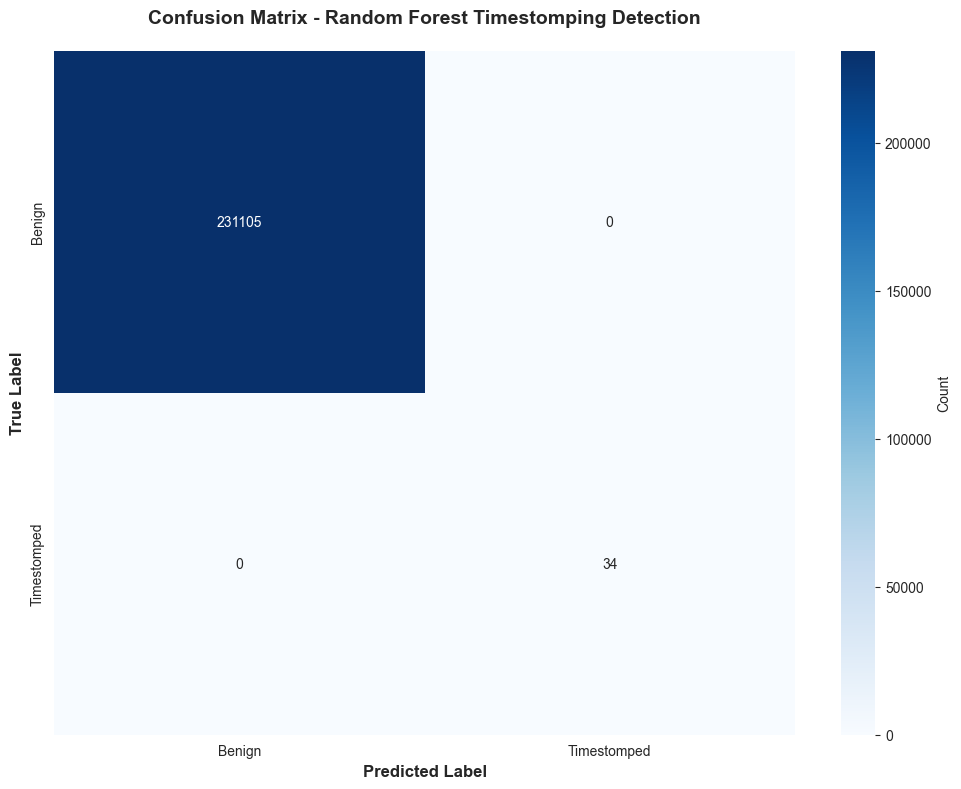

In [11]:
print("\n" + "=" * 80)
print("VISUALIZATION: CONFUSION MATRIX")
print("=" * 80)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Create confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Timestomped'],
            yticklabels=['Benign', 'Timestomped'],
            ax=ax, cbar_kws={'label': 'Count'})

ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - Random Forest Timestomping Detection', 
             fontsize=14, fontweight='bold', pad=20)

# Add text annotations for interpretation
if fp > 0:
    ax.text(0.5, -0.15, f'False Positives: {fp:,} (benign files incorrectly flagged)', 
            ha='center', transform=ax.transAxes, fontsize=10, color='red')
if fn > 0:
    ax.text(0.5, -0.20, f'False Negatives: {fn:,} (timestomped files missed)', 
            ha='center', transform=ax.transAxes, fontsize=10, color='darkred', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Saved: {OUTPUT_DIR / 'confusion_matrix.png'}")
plt.show()


---
## 9. Visualization: ROC Curve



VISUALIZATION: ROC CURVE

✅ Saved: data/processed/Phase 3 - Model Training/roc_curve.png


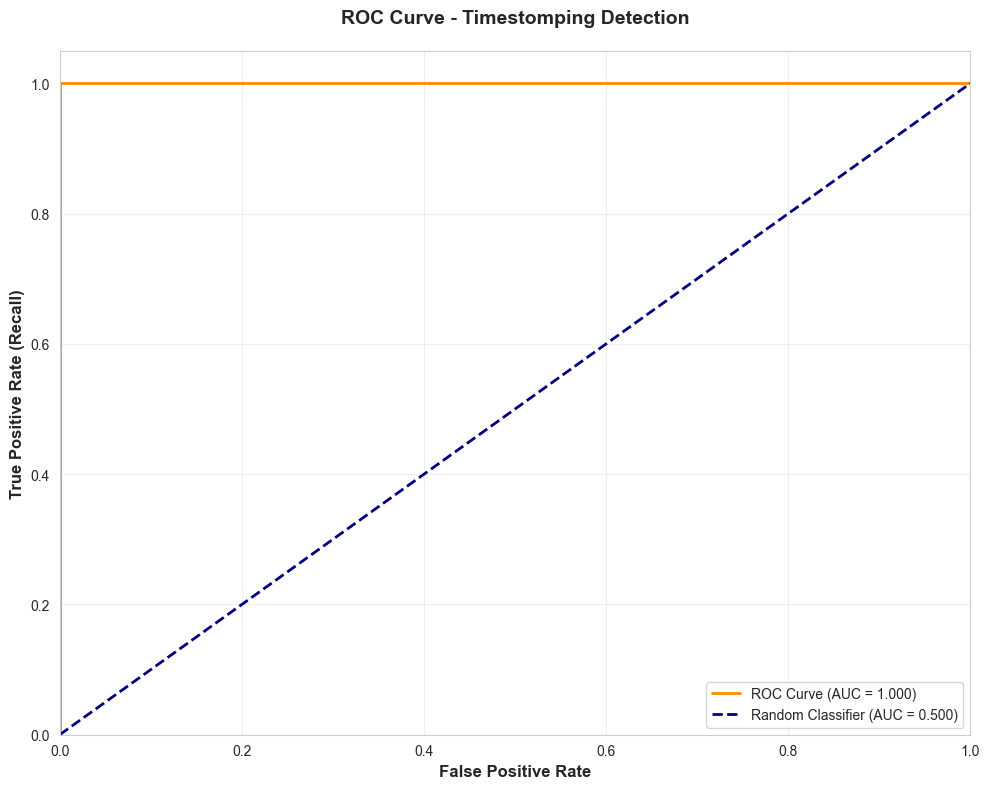

In [12]:
print("\n" + "=" * 80)
print("VISUALIZATION: ROC CURVE")
print("=" * 80)

if y_test.sum() > 0:
    # Calculate ROC curve
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_pred_proba)
    auc_roc = roc_auc_score(y_test, y_test_pred_proba)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Plot ROC curve
    ax.plot(fpr, tpr, color='darkorange', lw=2, 
            label=f'ROC Curve (AUC = {auc_roc:.3f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
            label='Random Classifier (AUC = 0.500)')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
    ax.set_title('ROC Curve - Timestomping Detection', fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc="lower right", fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'roc_curve.png', dpi=300, bbox_inches='tight')
    print(f"\n✅ Saved: {OUTPUT_DIR / 'roc_curve.png'}")
    plt.show()
else:
    print(f"\n⚠️  Cannot plot ROC curve - no timestomped events in test set")


---
## 10. Visualization: Precision-Recall Curve

**Why PR Curve is Important for Imbalanced Data:**
- More informative than ROC for rare events (timestomped files)
- Shows trade-off between precision and recall at different thresholds
- Helps choose optimal threshold based on forensic investigation priorities



VISUALIZATION: PRECISION-RECALL CURVE

✅ Saved: data/processed/Phase 3 - Model Training/precision_recall_curve.png


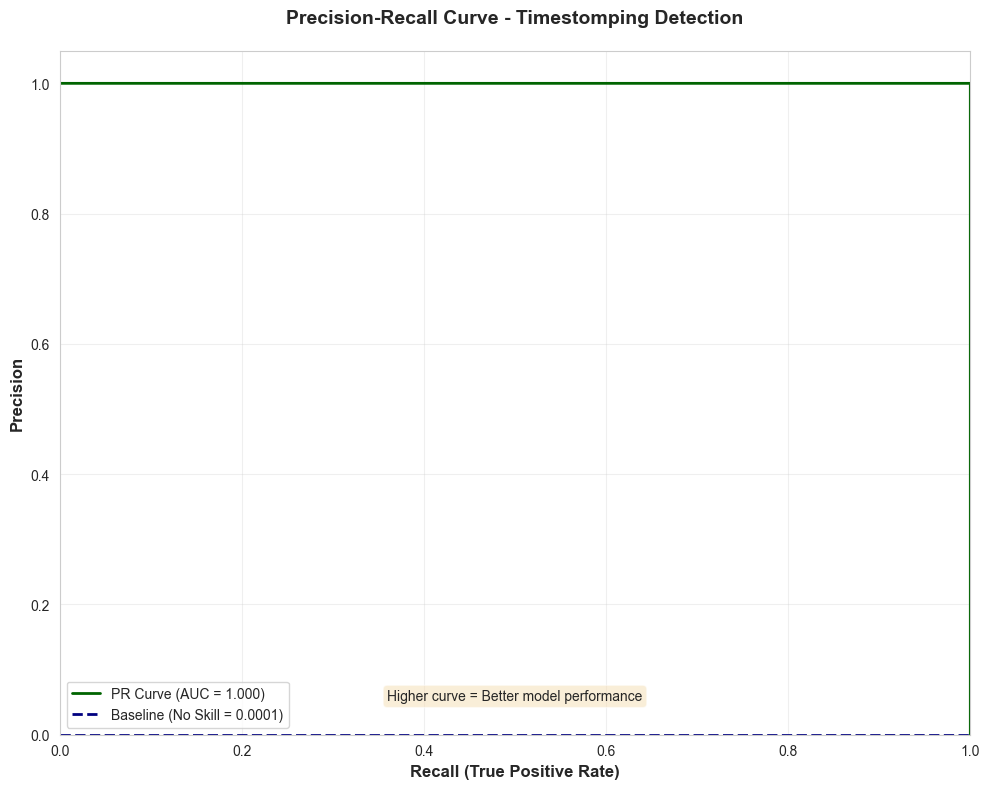

In [13]:
print("\n" + "=" * 80)
print("VISUALIZATION: PRECISION-RECALL CURVE")
print("=" * 80)

if y_test.sum() > 0:
    # Calculate PR curve
    precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_test_pred_proba)
    auc_pr = average_precision_score(y_test, y_test_pred_proba)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Plot PR curve
    ax.plot(recall_curve, precision_curve, color='darkgreen', lw=2,
            label=f'PR Curve (AUC = {auc_pr:.3f})')
    
    # Baseline (random classifier for imbalanced data)
    baseline = y_test.sum() / len(y_test)
    ax.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--',
            label=f'Baseline (No Skill = {baseline:.4f})')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall (True Positive Rate)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
    ax.set_title('Precision-Recall Curve - Timestomping Detection', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc="lower left", fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add annotation
    ax.text(0.5, 0.05, 'Higher curve = Better model performance',
            ha='center', transform=ax.transAxes, fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'precision_recall_curve.png', dpi=300, bbox_inches='tight')
    print(f"\n✅ Saved: {OUTPUT_DIR / 'precision_recall_curve.png'}")
    plt.show()
else:
    print(f"\n⚠️  Cannot plot PR curve - no timestomped events in test set")

---
## 11. Feature Importance Analysis

**Why Feature Importance Matters:**
- **Interpretability:** Understand which forensic indicators drive detection
- **Model Validation:** Ensure model uses meaningful patterns, not noise
- **Investigation Guidance:** Help forensic analysts focus on key artifacts

In [14]:
print("\n" + "=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

# 1. Extract feature importances
print(f"\n1️⃣ Extracting feature importances...")

feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"   Extracted importances for {len(feature_importances)} features")

# 2. Top 20 most important features
print(f"\n2️⃣ Top 20 Most Important Features:")
print(f"\n" + "─" * 80)

top_20 = feature_importances.head(20)
for idx, row in top_20.iterrows():
    bar = '█' * int(row['importance'] * 200)
    print(f"   {row['feature'][:40]:40s} {row['importance']:.4f} {bar}")

# 3. Feature importance by category
print(f"\n3️⃣ Feature Importance by Category:")
print(f"\n" + "─" * 80)

def categorize_feature(feat):
    if any(x in feat for x in ['hour', 'day', 'month', 'year', 'weekend', 'off_hours', 'delta', 'events_per']):
        return 'Temporal'
    elif any(x in feat for x in ['creation_after', 'accessed_before', 'mac_', 'future', 'year_delta', 'nanosec']):
        return 'Anomaly'
    elif any(x in feat for x in ['path_', 'filename_', 'system_path', 'temp_path', 'user_path', 'executable']):
        return 'Path'
    elif any(x in feat for x in ['event_encoded', 'rare_lf_event', 'rare_usn_event', 'consecutive', 'event_count_per_file']):
        return 'Event'
    elif any(x in feat for x in ['merge_', 'label_source_', 'has_logfile', 'has_usnjrnl', 'has_both', 'usn_attr']):
        return 'Cross-Artifact'
    elif feat.startswith('is_'):
        return 'Flags'
    else:
        return 'Other'

feature_importances['category'] = feature_importances['feature'].apply(categorize_feature)

category_importance = feature_importances.groupby('category')['importance'].agg(['sum', 'mean', 'count']).sort_values('sum', ascending=False)

print(f"   {'Category':<20} {'Total Imp':>12} {'Avg Imp':>12} {'Count':>8}")
print(f"   {'-'*20} {'-'*12} {'-'*12} {'-'*8}")
for cat, row in category_importance.iterrows():
    print(f"   {cat:<20} {row['sum']:12.4f} {row['mean']:12.4f} {int(row['count']):8d}")

print(f"\n✅ Feature importance analysis complete!")


FEATURE IMPORTANCE ANALYSIS

1️⃣ Extracting feature importances...
   Extracted importances for 79 features

2️⃣ Top 20 Most Important Features:

────────────────────────────────────────────────────────────────────────────────
   label_source_nan                         0.2166 ███████████████████████████████████████████
   lf_event_encoded                         0.1085 █████████████████████
   merge_matched                            0.1003 ████████████████████
   label_source_usnjrnl                     0.1000 ████████████████████
   has_both_artifacts                       0.0727 ██████████████
   is_temp_path                             0.0684 █████████████
   has_logfile_data                         0.0499 █████████
   merge_usnjrnl_only                       0.0445 ████████
   path_depth                               0.0253 █████
   is_off_hours                             0.0233 ████
   events_per_minute                        0.0232 ████
   usn_event_encoded                   

---
## 12. Visualization: Feature Importance


VISUALIZATION: FEATURE IMPORTANCE

✅ Saved: data/processed/Phase 3 - Model Training/feature_importance.png


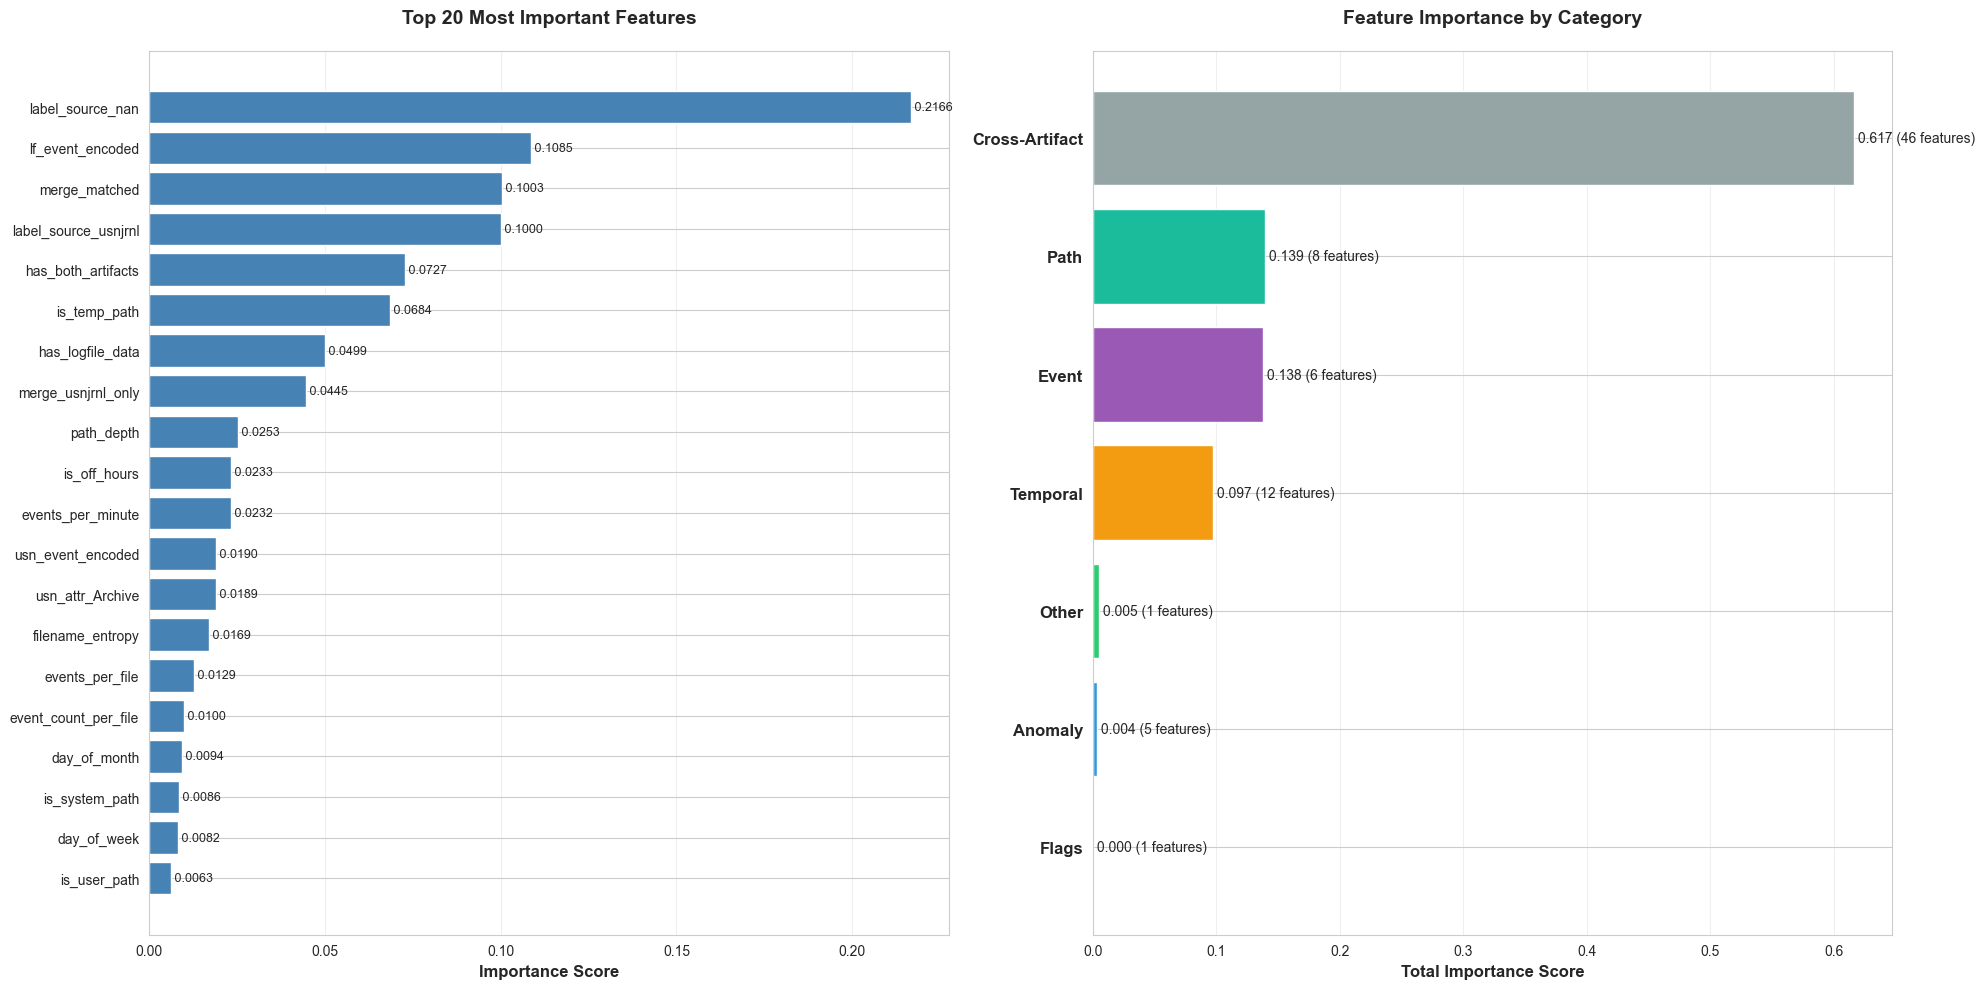

In [15]:
print("\n" + "=" * 80)
print("VISUALIZATION: FEATURE IMPORTANCE")
print("=" * 80)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: Top 20 Features
top_20 = feature_importances.head(20).sort_values('importance', ascending=True)

ax1.barh(range(len(top_20)), top_20['importance'], color='steelblue')
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels(top_20['feature'], fontsize=10)
ax1.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax1.set_title('Top 20 Most Important Features', fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_20.iterrows()):
    ax1.text(row['importance'], i, f" {row['importance']:.4f}", 
             va='center', fontsize=9)

# Plot 2: Category Importance
category_importance_sorted = category_importance.sort_values('sum', ascending=True)

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#95a5a6']
ax2.barh(range(len(category_importance_sorted)), category_importance_sorted['sum'], 
         color=colors[:len(category_importance_sorted)])
ax2.set_yticks(range(len(category_importance_sorted)))
ax2.set_yticklabels(category_importance_sorted.index, fontsize=12, fontweight='bold')
ax2.set_xlabel('Total Importance Score', fontsize=12, fontweight='bold')
ax2.set_title('Feature Importance by Category', fontsize=14, fontweight='bold', pad=20)
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, (cat, row) in enumerate(category_importance_sorted.iterrows()):
    ax2.text(row['sum'], i, f" {row['sum']:.3f} ({int(row['count'])} features)", 
             va='center', fontsize=10)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_importance.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Saved: {OUTPUT_DIR / 'feature_importance.png'}")
plt.show()

---
## 13. Save Model & Results

In [16]:
print("\n" + "=" * 80)
print("SAVING MODEL & RESULTS")
print("=" * 80)

# 1. Save trained model
print(f"\n1️⃣ Saving trained model...")

model_path = OUTPUT_DIR / 'random_forest_model.joblib'
joblib.dump(rf_model, model_path)
print(f"   ✅ Saved: {model_path}")

# 2. Save feature importance
print(f"\n2️⃣ Saving feature importance...")

importance_path = OUTPUT_DIR / 'feature_importance.csv'
feature_importances.to_csv(importance_path, index=False)
print(f"   ✅ Saved: {importance_path}")

# 3. Save evaluation metrics
print(f"\n3️⃣ Saving evaluation metrics...")

if y_test.sum() > 0:
    metrics_dict = {
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'true_positives': int(tp),
        'test_samples': len(y_test),
        'test_timestomped': int(y_test.sum()),
        'train_samples': len(X_train_resampled),
        'train_timestomped': int(y_train_resampled.sum())
    }
else:
    metrics_dict = {
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'auc_roc': 'N/A',
        'auc_pr': 'N/A',
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'true_positives': int(tp),
        'test_samples': len(y_test),
        'test_timestomped': int(y_test.sum()),
        'train_samples': len(X_train_resampled),
        'train_timestomped': int(y_train_resampled.sum())
    }

metrics_df = pd.DataFrame([metrics_dict])
metrics_path = OUTPUT_DIR / 'evaluation_metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"   ✅ Saved: {metrics_path}")

# 4. Save test predictions
print(f"\n4️⃣ Saving test predictions...")

predictions_df = pd.DataFrame({
    'y_true': y_test.values,
    'y_pred': y_test_pred,
    'y_pred_proba': y_test_pred_proba
})
predictions_path = OUTPUT_DIR / 'test_predictions.csv'
predictions_df.to_csv(predictions_path, index=False)
print(f"   ✅ Saved: {predictions_path}")

print(f"\n✅ All results saved to: {OUTPUT_DIR}")


SAVING MODEL & RESULTS

1️⃣ Saving trained model...
   ✅ Saved: data/processed/Phase 3 - Model Training/random_forest_model.joblib

2️⃣ Saving feature importance...
   ✅ Saved: data/processed/Phase 3 - Model Training/feature_importance.csv

3️⃣ Saving evaluation metrics...
   ✅ Saved: data/processed/Phase 3 - Model Training/evaluation_metrics.csv

4️⃣ Saving test predictions...
   ✅ Saved: data/processed/Phase 3 - Model Training/test_predictions.csv

✅ All results saved to: data/processed/Phase 3 - Model Training


---
## 14. Summary & Key Findings


In [17]:
print("\n" + "=" * 80)
print("PHASE 3 SUMMARY: MODEL TRAINING & EVALUATION")
print("=" * 80)

print(f"\n📊 Dataset Statistics:")
print(f"   Total samples: {len(X):,}")
print(f"   Total features: {X.shape[1]}")
print(f"   Timestomped events: {y.sum()}")
print(f"   Class imbalance: 1:{int((y == 0).sum() / y.sum())}")

print(f"\n🔄 Data Split:")
print(f"   Train: {len(X_train):,} samples → {len(X_train_resampled):,} after SMOTE")
print(f"   Test:  {len(X_test):,} samples (unchanged)")
print(f"   Train cases: {len(train_cases)}")
print(f"   Test cases:  {len(test_cases)}")

print(f"\n🎯 Model Performance:")
print(f"   Precision: {test_precision:.3f} ({test_precision*100:.1f}%)")
print(f"   Recall:    {test_recall:.3f} ({test_recall*100:.1f}%)")
print(f"   F1-Score:  {test_f1:.3f}")
if y_test.sum() > 0:
    print(f"   AUC-ROC:   {auc_roc:.3f}")
    print(f"   AUC-PR:    {auc_pr:.3f}")

print(f"\n📈 Confusion Matrix:")
print(f"   True Positives:  {tp:,}")
print(f"   False Positives: {fp:,}")
print(f"   True Negatives:  {tn:,}")
print(f"   False Negatives: {fn:,}")

print(f"\n🔍 Top 5 Most Important Features:")
for idx, (_, row) in enumerate(feature_importances.head(5).iterrows(), 1):
    print(f"   {idx}. {row['feature']} ({row['importance']:.4f})")

print(f"\n💡 Key Insights:")
if test_recall >= 0.85:
    print(f"   ✓ High recall ({test_recall:.1%}) - Model catches most timestomped files")
else:
    print(f"   ⚠️  Low recall ({test_recall:.1%}) - Model misses some timestomped files")

if test_precision >= 0.90:
    print(f"   ✓ High precision ({test_precision:.1%}) - Few false alarms")
else:
    print(f"   ⚠️  Moderate precision ({test_precision:.1%}) - Some false alarms expected")

if category_importance.loc['Anomaly', 'sum'] > 0.1:
    print(f"   ✓ Anomaly features are highly predictive (forensically meaningful)")

print(f"\n📁 Outputs Saved:")
print(f"   - Model: {OUTPUT_DIR / 'random_forest_model.joblib'}")
print(f"   - Feature Importance: {OUTPUT_DIR / 'feature_importance.csv'}")
print(f"   - Metrics: {OUTPUT_DIR / 'evaluation_metrics.csv'}")
print(f"   - Predictions: {OUTPUT_DIR / 'test_predictions.csv'}")
print(f"   - Visualizations: confusion_matrix.png, roc_curve.png, precision_recall_curve.png, feature_importance.png")

print(f"\n🎉 Phase 3 Complete!")
print(f"   Model is ready for deployment in Autopsy plugin prototype")
print("=" * 80)



PHASE 3 SUMMARY: MODEL TRAINING & EVALUATION

📊 Dataset Statistics:
   Total samples: 778,692
   Total features: 79
   Timestomped events: 247.0
   Class imbalance: 1:3151

🔄 Data Split:
   Train: 547,553 samples → 552,813 after SMOTE
   Test:  231,139 samples (unchanged)
   Train cases: 9
   Test cases:  3

🎯 Model Performance:
   Precision: 1.000 (100.0%)
   Recall:    1.000 (100.0%)
   F1-Score:  1.000
   AUC-ROC:   1.000
   AUC-PR:    1.000

📈 Confusion Matrix:
   True Positives:  34
   False Positives: 0
   True Negatives:  231,105
   False Negatives: 0

🔍 Top 5 Most Important Features:
   1. label_source_nan (0.2166)
   2. lf_event_encoded (0.1085)
   3. merge_matched (0.1003)
   4. label_source_usnjrnl (0.1000)
   5. has_both_artifacts (0.0727)

💡 Key Insights:
   ✓ High recall (100.0%) - Model catches most timestomped files
   ✓ High precision (100.0%) - Few false alarms

📁 Outputs Saved:
   - Model: data/processed/Phase 3 - Model Training/random_forest_model.joblib
   - Featu